### **Project 2. Potential Temperature, Potential Vorticity and Ozone Mixing Ratio**

##### Object: Calculate potential temperature and make figures of potential temperature, potential vorticity and ozone mixing ratio

In [2]:
### 0. Calling packages


import sys
import math
import numpy as np
import numpy.ma as ma
import netCDF4 as nc4
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               LogLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from collections import OrderedDict

In [3]:
### 1. python의 netCDF4 모듈을 이용하여 하나의 .nc4 파일 읽기 


rdir = '.'
fname = rdir+'/for_Q2_MERRA2_300.inst3_3d_asm_Np.20020512.nc4'
dataset = nc4.Dataset(fname, 'r')

dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    History: Original file generated: Mon Jul  7 19:06:30 2014 GMT
    Comment: GMAO filename: d5124_m2_jan00.inst3_3d_asm_Np.20020512.nc4
    Filename: MERRA2_300.inst3_3d_asm_Np.20020512.nc4
    Conventions: CF-1
    Institution: NASA Global Modeling and Assimilation Office
    References: http://gmao.gsfc.nasa.gov
    Format: NetCDF-4/HDF-5
    SpatialCoverage: global
    VersionID: 5.12.4
    TemporalRange: 1980-01-01 -> 2016-12-31
    identifier_product_doi_authority: http://dx.doi.org/
    ShortName: M2I3NPASM
    GranuleID: MERRA2_300.inst3_3d_asm_Np.20020512.nc4
    ProductionDateTime: Original file generated: Mon Jul  7 19:06:30 2014 GMT
    LongName: MERRA2 inst3_3d_asm_Np: 3d,3-Hourly,Instantaneous,Pressure-Level,Assimilation,Assimilated Meteorological Fields
    Title: MERRA2 inst3_3d_asm_Np: 3d,3-Hourly,Instantaneous,Pressure-Level,Assimilation,Assimilated Meteorological Fields
  

In [4]:
### 2-1. 읽은 파일에서 축에 대한 정보를 읽어 저장하기


rlon = dataset.variables['lon'][:]
rlat = dataset.variables['lat'][:]
rlev = dataset.variables['lev'][:]
rtim = (dataset.variables['time'])[:]

/tmp/ipykernel_506/2283792715.py:7: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  rtim = (dataset.variables['time'])[:]


In [5]:
### 2-2. 읽은 파일에서 변수에 대한 정보를 읽어 저장하기


u = (dataset.variables['U'])[:]
v = (dataset.variables['V'])[:]
omega = (dataset.variables['OMEGA'])[:]
T = (dataset.variables['T'])[:]
o3 = (dataset.variables['O3'])[:] 
epv = (dataset.variables['EPV'])[:]

In [6]:
### 3-1. Horizontal grid setting


def grid_boundary(lon, lat):
    
    nlon = lon.shape[0]
    nlat = lat.shape[0]
    dlon = lon[1]-lon[0]   # uniform longitude assumed
    dlat = lat[1]-lat[0]   # uniform latitude assumed
    
    # extend array by one cell
    lon_b = np.concatenate((lon, np.zeros(1, dtype=lon.dtype)))
    lon_b[0:nlon] = lon[0:nlon] - dlon * 0.5
    lon_b[nlon]   = lon[nlon-1] + dlon * 0.5
    
    lat_b = lat[0:nlat-1]       # +/-90deg is excluded
    lat_b = lat_b + dlat * 0.5
    
    nlon_b = lon_b.shape[0]
    nlat_b = lat_b.shape[0]
    
    
    lon_b_2d = np.tile(lon_b, (nlat_b, 1))
    lat_b_2d = np.transpose(np.tile(lat_b, (nlon_b, 1)))
    
    return(lon_b_2d, lat_b_2d)


print(sys.version)

3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]


In [7]:
# 3-2. Horizontal grid setting


rlon2d, rlat2d = grid_boundary(rlon, rlat)
nlon = rlon.shape[0]
nlat = rlat.shape[0]
nlon2d = rlon2d.shape[1]
nlat2d = rlon2d.shape[0]

print(nlon)
print(nlat)
print(rlon2d.shape)

576
361
(360, 577)


In [8]:
### Q1-1. Project 1와 비교하여, Project 2 MERRA2 데이터에서 없어진 변수는 무엇이고 생긴것은 무엇일까?
#         새로 생긴 변수는 몇 차원인가? 단위는 무엇인가?


# 없어진 변수: SLP(3차원, 8*361*576)
# 새로 생긴 변수: o3(4차원, 8*42*361*576), 단위 kg kg $^{-1}$ (mixing ratio), 그림 그릴 때 10 $^{-6}$ kg kg $^{-1}$ 사용

In [16]:
### Q1-2. potential temperature를 계산하고 array로 저장하라.
#         (건조공기에 대한 기체상수 R = 287. J/kg/K, 정압비열 cp = 1004. J/kg/K, standard pressure Ps = 1000 hPa로 가정)


# potential temperature theta

# theta = T(p)(P0 / P) $^{k}$
# 여기서 P0 = Ps, k(kappa)는 아래와 같이 R / cp 로 계산


# 계산을 위한 4차원 lev array 생성하기

lev = np.zeros([8,42,361,576])

for nlev in range(42):
    lev[:,nlev,:,:] = rlev[nlev]


# 필요한 상수들 정의하기

R = 287.
cp = 1004.
Ps = 1000.
k = R / cp


pt = np.zeros([8, 42, 361, 576])

pt = T * (Ps / lev)**k

print(pt)

[[[[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [268.71099853515625 268.70953369140625 268.70758056640625 ...
    268.71539306640625 268.71392822265625 268.71246337890625]
   [268.37896728515625 268.37701416015625 268.37554931640625 ...
    268.38433837890625 268.38287353515625 268.38092041015625]
   [267.99908447265625 267.99908447265625 267.99908447265625 ...
    267.99908447265625 267.99908447265625 267.99908447265625]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   ...
   [269.1294497478353 269.11961319008026 269.1097766323252 ...
    269.15699210954944 269.14715555179436 269.13928630559036]
   [269.01731298942775 269.0114110547747 269.00747643167267 ...
    269.0310841702848 269.0271495471828 269.02124761252975]
   [268.8245164574288 268.8245164574288 268.8245164574288 ...
    268.8245164574288 268.8245164574288 268.8245164574288]]

  [[-- -- -- ... -- -- --]
   [-- -- -- ... -- -- --]
   [-- -- -- ..

In [17]:
### Q1-3. Potential temperature, Ertel's potential vorticity, ozone mixing ratio에 대하여
#         300 hPa 고도에서 각각 변수의 최대값, 최소값을 출력


# 300 hPa 고도는 rlev 리스트 인덱스 상으로 20번

print(np.max(pt[:, 20, :, :]))
print(np.min(pt[:, 20, :, :]))

print(np.max(epv[:, 20, :, :]))
print(np.min(epv[:, 20, :, :]))

print(np.max(o3[:, 20, :, :]))
print(np.min(o3[:, 20, :, :]))

352.70158188643774
292.41720963119826
1.4775222e-05
-9.927763e-06
7.7310153e-07
1.4605456e-08


In [18]:
rlev

masked_array(data=[1.00000000e+03, 9.75000000e+02, 9.50000000e+02,
                   9.25000000e+02, 9.00000000e+02, 8.75000000e+02,
                   8.50000000e+02, 8.25000000e+02, 8.00000000e+02,
                   7.75000000e+02, 7.50000000e+02, 7.25000000e+02,
                   7.00000000e+02, 6.50000000e+02, 6.00000000e+02,
                   5.50000000e+02, 5.00000000e+02, 4.50000000e+02,
                   4.00000000e+02, 3.50000000e+02, 3.00000000e+02,
                   2.50000000e+02, 2.00000000e+02, 1.50000000e+02,
                   1.00000000e+02, 7.00000000e+01, 5.00000000e+01,
                   4.00000000e+01, 3.00000000e+01, 2.00000000e+01,
                   1.00000000e+01, 7.00000000e+00, 5.00000000e+00,
                   4.00000000e+00, 3.00000000e+00, 2.00000000e+00,
                   1.00000000e+00, 6.99999988e-01, 5.00000000e-01,
                   4.00000006e-01, 3.00000012e-01, 1.00000001e-01],
             mask=False,
       fill_value=1e+20)

In [19]:
### Q2. Q1에서 알아본 세 개의 변수에 대한 그림을 300 hPa 고도에서 남극 방향에 대해 polar projection을 하여 하나의 그림으로 나타내라. (12 JST에 대해)

#       * 다음 항목은 그림에 반드시 나타낼 것

#         (a) 세 개 그림 모두 90°S ~ 30°S 까지 projection 할 것.
#         (b) 그림 대제목 및 (a), (b), (c) 소제목 반드시 포함
#         (c) 그림 아래쪽에 colorbar를 그릴 것, colorbar 색 간격은 각 변수의 최소값 최대값을 고려하여 자유롭게 특징이 나타나도록 할 것,
#             또 colorbar의 아래에 단위를 표시할 것.

In [20]:
# 그림을 그리기 위해 12 JST(03 UTC), 300hPa에서의 변수들을 선언해 주기, 그림에서 표시할 단위로 변환해주기

pt_300 = pt[1, 20, :360, :576]
epv_300 = epv[1, 20, :360, :576] * 10**6
o3_300 = o3[1, 20, :360, :576] * 10**6

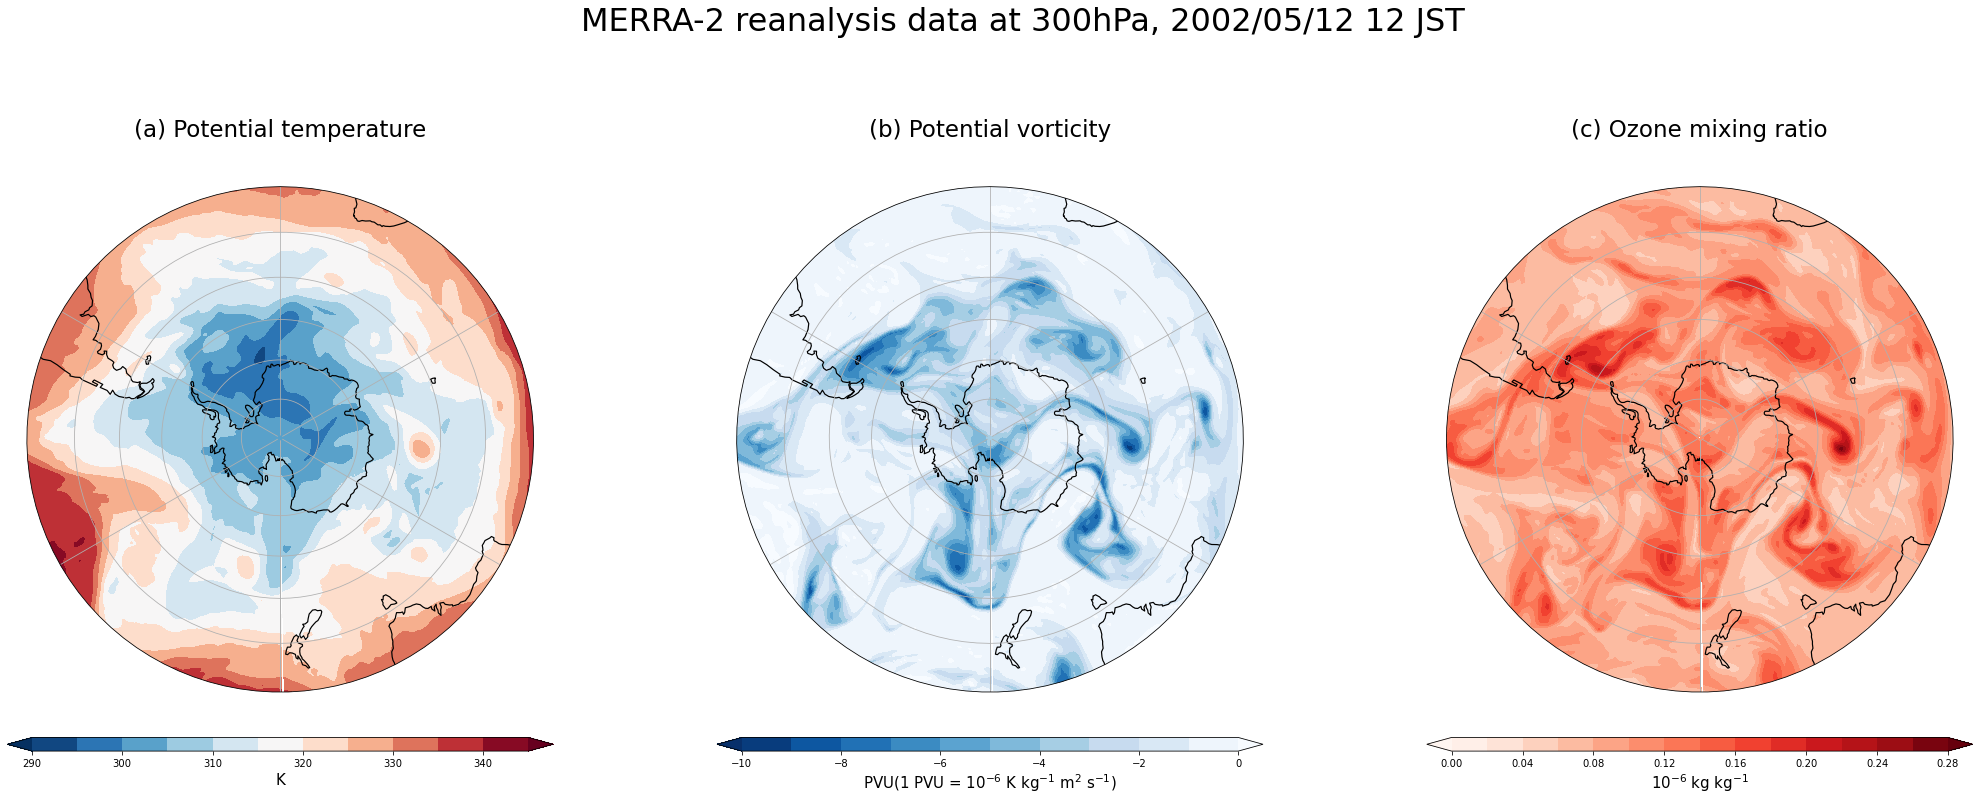

In [21]:
# cartopy library를 이용하여 전체적인 figure 생성하기

fig = plt.figure(figsize=(30, 10)) # 그림 3개니까 3의 배수로

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.3)


# 대제목 설정하기

plt.suptitle('MERRA-2 reanalysis data at 300hPa, 2002/05/12 12 JST', x = 0.51, y = 1.2, fontsize = 32)


# Potential temperature figure 그리기

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())  # 경도 및 위도 범위 설정, 경도는 -180부터 180까지, 위도는 -90부터 -30까지

ax1.gridlines()

ax1.set_boundary(circle, transform=ax1.transAxes) # cartopy Custom Boundary Shape의 경우 기본적으로 생성되는 모양이 사각형인데, 이것을 원으로 바꿔줌

ax1.set_title('(a) Potential temperature', fontdict = {'fontsize': 23}, pad = 50)

cs1 = ax1.contourf(rlon2d[:, :576], rlat2d[:, :576], pt_300, levels = np.arange(290, 350, 5),
                cmap = 'RdBu_r', extend = 'both', transform=ccrs.PlateCarree())

ax1.coastlines(resolution='110m', linewidth=1.2)


# Potential temperature figure's colorbar

clb1 = plt.colorbar(cs1, orientation = 'horizontal', aspect = 40, pad = 0.07)
clb1.set_label('K', fontsize = 15)


# Potential vorticity figure 그리기

ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo(),
                      sharex=ax1, sharey=ax1)

ax2.gridlines()

ax2.set_boundary(circle, transform=ax2.transAxes)

ax2.set_title('(b) Potential vorticity', fontdict = {'fontsize': 23}, pad = 50)

cs2 = ax2.contourf(rlon2d[:, :576], rlat2d[:, :576], epv_300, levels = np.arange(-10, 1, 1),
                  cmap = 'Blues_r', extend = 'both', transform=ccrs.PlateCarree())  # contourf 괄호 안 순서: x축, y축, 변수...

ax2.coastlines(resolution='110m', linewidth=1.2)


# Potential vorticity figure's colorbar

clb2 = plt.colorbar(cs2, orientation = 'horizontal', aspect = 40, pad = 0.07)
clb2.set_label('PVU(1 PVU = 10$^{-6}$ K kg$^{-1}$ m$^{2}$ s$^{-1}$)', fontsize = 15)


# Ozone mixing ratio figure 그리기

ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo(),
                      sharex=ax1, sharey=ax1)

ax3.gridlines()

ax3.set_boundary(circle, transform=ax3.transAxes)

ax3.set_title('(c) Ozone mixing ratio', fontdict = {'fontsize': 23}, pad = 50)

cs3 = ax3.contourf(rlon2d[:, :576], rlat2d[:, :576], o3_300, levels = np.arange(0.00, 0.28, 0.02),
                  cmap = 'Reds', extend = 'both', transform=ccrs.PlateCarree())

ax3.coastlines(resolution='110m', linewidth=1.2)


# Ozone mixing ratio figure's colorbar

clb3 = plt.colorbar(cs3, orientation = 'horizontal', aspect = 40, pad = 0.07)
clb3.set_label('10$^{-6}$ kg kg$^{-1}$', fontsize = 15)